In [1]:
import time
import sys
import random
from typing import List
from ukkonen import SuffixTree
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def build_suffix_array(text: str):
    return sorted(range(len(text)), key=lambda i: text[i:])

def search_pattern_suffix_array(text: str, suffix_array: List[int], pattern: str) -> List[int]:
    def compare_suffix(i, pattern):
        suffix = text[i:i+len(pattern)]
        if len(suffix) < len(pattern): return 1
        return (suffix > pattern) - (suffix < pattern)
    
    left, right = 0, len(suffix_array)
    while left < right:
        mid = (left + right) // 2
        if compare_suffix(suffix_array[mid], pattern) < 0: left = mid + 1
        else:  right = mid
    
    if left >= len(suffix_array) or not text[suffix_array[left]:].startswith(pattern): return []

    result = []
    i = left
    while i < len(suffix_array) and text[suffix_array[i]:].startswith(pattern):
        result.append(suffix_array[i])
        i += 1
    
    return result

def search_pattern_suffix_tree(suffix_tree: SuffixTree, pattern: str) -> List[int]:
    try:
        positions = suffix_tree.find(pattern)
        return positions if positions else []
    except:  return []

def compare_suffix_structures(text: str) -> dict:
    result = {
        "suffix_array": {
            "construction_time_ms": 0,
            "memory_usage_kb": 0,
            "size": 0,
            "search_time_ms": 0
        },
        "suffix_tree": {
            "construction_time_ms": 0,
            "memory_usage_kb": 0,
            "size": 0,
            "search_time_ms": 0
        }
    }
    

    start_time = time.time()
    sa = build_suffix_array(text)
    end_time = time.time()
    result["suffix_array"]["construction_time_ms"] = (end_time - start_time) * 1000
    result["suffix_array"]["memory_usage_kb"] = sys.getsizeof(sa) / 1024
    result["suffix_array"]["size"] = len(sa)
    

    start_time = time.time()
    st = SuffixTree(text)
    end_time = time.time()
    result["suffix_tree"]["construction_time_ms"] = (end_time - start_time) * 1000
    
    def get_tree_memory(node):
        size = sys.getsizeof(node) + sys.getsizeof(node.children)
        for child in node.children.values(): size += get_tree_memory(child)
        return size
    result["suffix_tree"]["memory_usage_kb"] = get_tree_memory(st.root) / 1024
    
    def count_nodes(node):return 1 + sum(count_nodes(child) for child in node.children.values())
    result["suffix_tree"]["size"] = count_nodes(st.root)
    
    test_patterns = []
    for pattern_len in [3, 5, 8]:
        if len(text) >= pattern_len + 10:
            start_pos = random.randint(0, len(text) - pattern_len)
            test_patterns.append(text[start_pos:start_pos + pattern_len])
    
    for pattern_len in [3, 5]:
        if len(text) >= pattern_len: test_patterns.append(''.join(random.choices('ACGT', k=pattern_len)))
    
    sa_search_times = []
    for pattern in test_patterns:
        start_time = time.time()
        search_pattern_suffix_array(text, sa, pattern)
        end_time = time.time()
        sa_search_times.append((end_time - start_time) * 1000)
    
    result["suffix_array"]["search_time_ms"] = np.mean(sa_search_times) if sa_search_times else 0
    
    st_search_times = []
    for pattern in test_patterns:
        start_time = time.time()
        search_pattern_suffix_tree(st, pattern)
        end_time = time.time()
        st_search_times.append((end_time - start_time) * 1000)
    
    result["suffix_tree"]["search_time_ms"] = np.mean(st_search_times) if st_search_times else 0
    
    return result

def generate_test_text(length: int) -> str: return ''.join(random.choices('ACGT', k=length))

def run_scaling_analysis():
    text_lengths = [100, 500, 1000, 2000, 5000, 8000, 10000, 15000, 20000]
    
    sa_times = []
    st_times = []
    sa_memory = []
    st_memory = []
    sa_sizes = []
    st_sizes = []
    sa_search_times = []
    st_search_times = []
    
    print("Running scaling analysis...")
    for i, length in enumerate(text_lengths):
        print(f"Progress: {i+1}/{len(text_lengths)} - Testing with text length: {length}")
        text = generate_test_text(length)
        
        iterations = 3
        sa_time_samples = []
        st_time_samples = []
        sa_search_samples = []
        st_search_samples = []
        
        for _ in range(iterations):
            results = compare_suffix_structures(text)
            sa_time_samples.append(results["suffix_array"]["construction_time_ms"])
            st_time_samples.append(results["suffix_tree"]["construction_time_ms"])
            sa_search_samples.append(results["suffix_array"]["search_time_ms"])
            st_search_samples.append(results["suffix_tree"]["search_time_ms"])
        
        sa_times.append(np.median(sa_time_samples))
        st_times.append(np.median(st_time_samples))
        sa_search_times.append(np.median(sa_search_samples))
        st_search_times.append(np.median(st_search_samples))
        
        sa_memory.append(results["suffix_array"]["memory_usage_kb"])
        st_memory.append(results["suffix_tree"]["memory_usage_kb"])
        sa_sizes.append(results["suffix_array"]["size"])
        st_sizes.append(results["suffix_tree"]["size"])

    text_lengths = np.array(text_lengths)
    sa_times = np.array(sa_times)
    st_times = np.array(st_times)
    sa_memory = np.array(sa_memory)
    st_memory = np.array(st_memory)
    sa_sizes = np.array(sa_sizes)
    st_sizes = np.array(st_sizes)
    sa_search_times = np.array(sa_search_times)
    st_search_times = np.array(st_search_times)
    fig = plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(text_lengths, sa_times, 'b-o', label='Suffix Array', markersize=5, linewidth=2)
    plt.plot(text_lengths, st_times, 'r-o', label='Suffix Tree', markersize=5, linewidth=2)
    plt.xlabel('Text Length (n)', fontsize=10)
    plt.ylabel('Construction Time (ms)', fontsize=10)
    plt.title('Construction Time Complexity (Linear Scale)', fontsize=11, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.plot(text_lengths, sa_memory, 'b-o', label='Suffix Array', markersize=5, linewidth=2)
    plt.plot(text_lengths, st_memory, 'r-o', label='Suffix Tree', markersize=5, linewidth=2)
    plt.xlabel('Text Length (n)', fontsize=10)
    plt.ylabel('Memory Usage (KB)', fontsize=10)
    plt.title('Memory Usage Complexity (Linear Scale)', fontsize=11, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.plot(text_lengths, sa_search_times, 'b-o', label='Suffix Array Search', markersize=5, linewidth=2)
    plt.plot(text_lengths, st_search_times, 'r-o', label='Suffix Tree Search', markersize=5, linewidth=2)
    plt.xlabel('Text Length (n)', fontsize=10)
    plt.ylabel('Search Time (ms)', fontsize=10)
    plt.title('Pattern Search Time Comparison (Linear Scale)', fontsize=11, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.plot(text_lengths, sa_sizes, 'b-o', label='Suffix Array', markersize=5, linewidth=2)
    plt.plot(text_lengths, st_sizes, 'r-o', label='Suffix Tree', markersize=5, linewidth=2)
    plt.xlabel('Text Length (n)', fontsize=10)
    plt.ylabel('Structure Size (elements)', fontsize=10)
    plt.title('Structure Size Comparison (Linear Scale)', fontsize=11, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    

    print("\n" + "="*60)
    print("COMPLEXITY ANALYSIS SUMMARY")
    print("="*60)
    
    if len(text_lengths) > 2:
        log_n = np.log(text_lengths)
        log_sa_time = np.log(sa_times)
        log_st_time = np.log(st_times)
        
        sa_slope, sa_intercept, sa_r, _, _ = stats.linregress(log_n, log_sa_time)
        st_slope, st_intercept, st_r, _, _ = stats.linregress(log_n, log_st_time)
        
        print(f"Suffix Array:")
        print(f"  Empirical complexity: O(n^{sa_slope:.2f})")
        print(f"  Theoretical complexity: O(n log n) ≈ O(n^1.2)")
        print(f"  R² correlation: {sa_r**2:.3f}")
        print(f"  Average construction time: {np.mean(sa_times):.2f} ms")
        print(f"  Average search time: {np.mean(sa_search_times):.4f} ms")
        print()
        print(f"Suffix Tree:")
        print(f"  Empirical complexity: O(n^{st_slope:.2f})")
        print(f"  Theoretical complexity: O(n)")
        print(f"  R² correlation: {st_r**2:.3f}")
        print(f"  Average construction time: {np.mean(st_times):.2f} ms")
        print(f"  Average search time: {np.mean(st_search_times):.4f} ms")
        print()

        avg_ratio = np.mean(st_times / sa_times)
        search_ratio = np.mean(st_search_times / sa_search_times) if np.mean(sa_search_times) > 0 else 0
        
        print(f"Performance Summary:")
        print(f"  Average ST/SA construction time ratio: {avg_ratio:.2f}")
        if avg_ratio < 1:
            print(f"  Suffix Tree construction is {1/avg_ratio:.1f}x faster on average")
        else:
            print(f"  Suffix Array construction is {avg_ratio:.1f}x faster on average")
        
        if search_ratio > 0:
            print(f"  Average ST/SA search time ratio: {search_ratio:.2f}")
            if search_ratio < 1:
                print(f"  Suffix Tree search is {1/search_ratio:.1f}x faster on average")
            else:
                print(f"  Suffix Array search is {search_ratio:.1f}x faster on average")
        
        print(f"  Memory efficiency (SA/ST): {np.mean(sa_memory/st_memory):.2f}")
        
    print("="*60)
    print("Wniosek: Pamięć jest za darmo")


Running scaling analysis...
Progress: 1/9 - Testing with text length: 100
Progress: 2/9 - Testing with text length: 500
Progress: 3/9 - Testing with text length: 1000
Progress: 4/9 - Testing with text length: 2000
Progress: 5/9 - Testing with text length: 5000
Progress: 6/9 - Testing with text length: 8000
Progress: 7/9 - Testing with text length: 10000
Progress: 8/9 - Testing with text length: 15000
Progress: 9/9 - Testing with text length: 20000


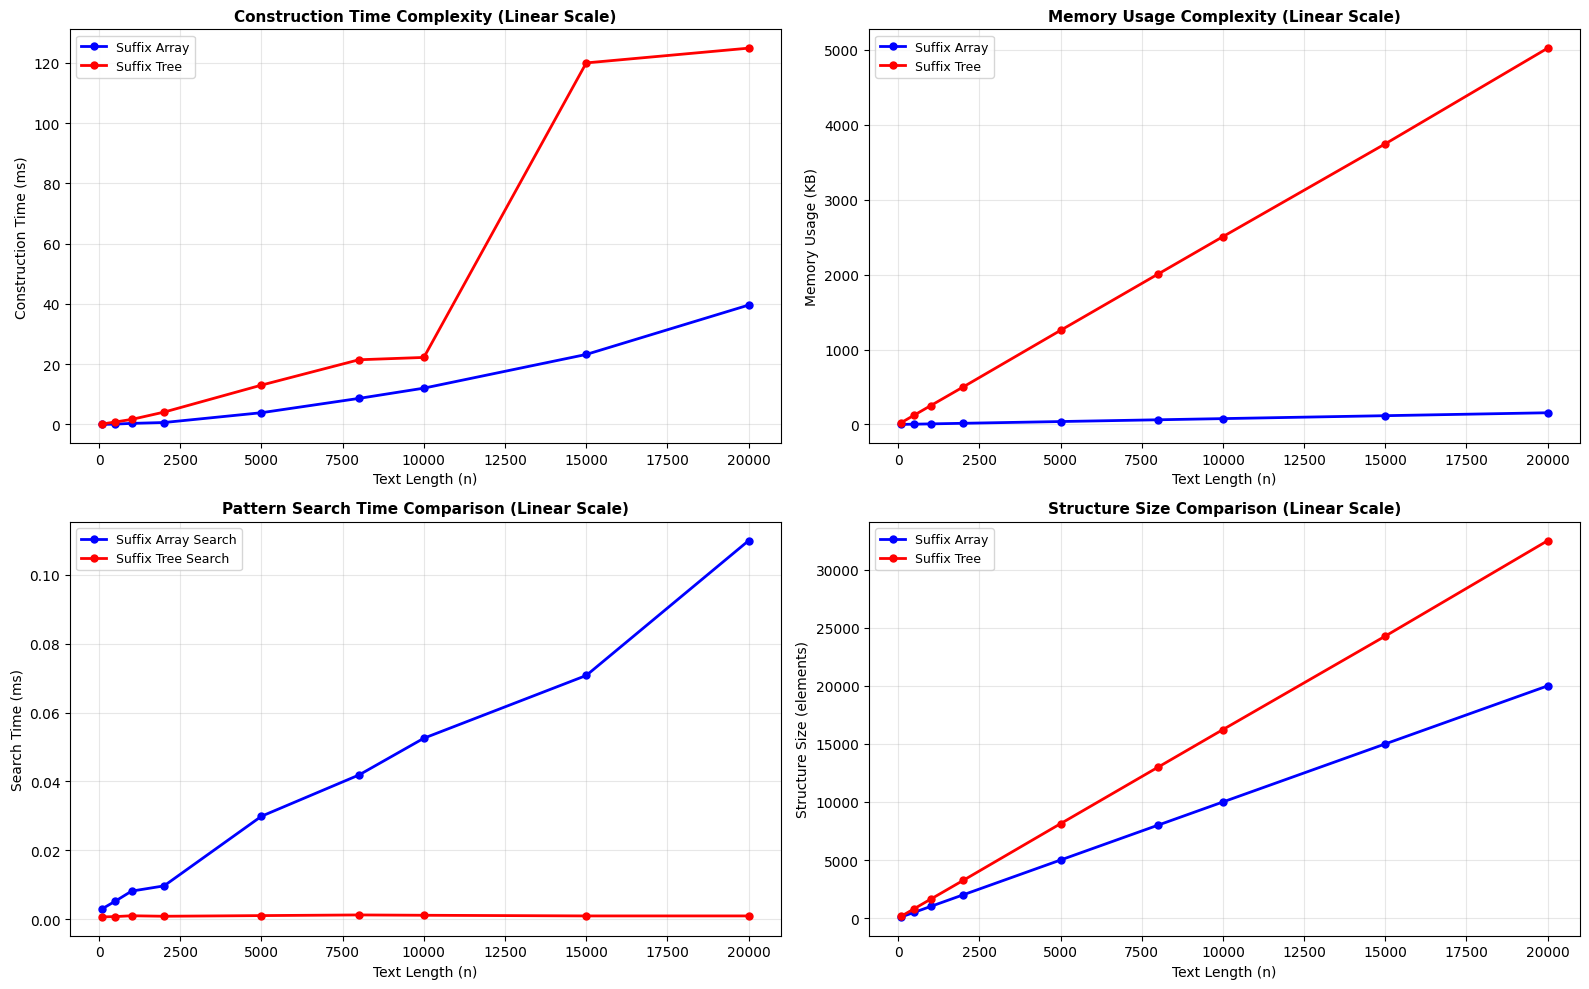


COMPLEXITY ANALYSIS SUMMARY
Suffix Array:
  Empirical complexity: O(n^1.47)
  Theoretical complexity: O(n log n) ≈ O(n^1.2)
  R² correlation: 0.991
  Average construction time: 9.84 ms
  Average search time: 0.0368 ms

Suffix Tree:
  Empirical complexity: O(n^1.25)
  Theoretical complexity: O(n)
  R² correlation: 0.971
  Average construction time: 34.26 ms
  Average search time: 0.0010 ms

Performance Summary:
  Average ST/SA construction time ratio: 4.79
  Suffix Array construction is 4.8x faster on average
  Average ST/SA search time ratio: 0.08
  Suffix Tree search is 13.2x faster on average
  Memory efficiency (SA/ST): 0.03
Wniosek: Pamięć jest za darmo


In [2]:
run_scaling_analysis()

### Uzycie tablicy suffixow

- mała struktura o dobrej wydalności pamięciowej i prostocie implementacji

- rzadkie i szybkie wyszukiwania

- wystarczajacy bedzie dosep do pozycji suffixow w porzadku leksykograficznym

### Uzycie drzewa suffixow:

- duża liczba zapytań

- mamy dużo pamięci i zależy nam bardziej na szybkości operacji po zbudowanych strukturach

- praca na zmiennych / dynamiczne aktualizowanych danych

- używanie złożonych operacji tekstowych


### Podsumowanie

Mimo, że konstrukcja drzewa suffixów zajmuej zdecydowanie więcej czasu niż tablica suffixow, to wyszukiwanie po drzewie jest znacznie szybsze niz po tablicy